# Fourier Components Don't Phase Me

Coincidentally, the use of Fourier components in regression models has come up twice this week, on two separate projects.
This notebook presents a small example to show how they work.

Note: The title of this article is a play on the [homophones "phase" and "faze"](https://www.merriam-webster.com/grammar/phase-vs-faze).

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/examples/fourier.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.printoptions(legacy='1.25')
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = [6, 3.5]

Suppose we have a signal that contains a periodic component parameterized by frequency `f`, amplitude `A`, and phase shift `phi`.
I'll give these parameters arbitrary values and we'll see if we can recover them.

In [2]:
f = 1
A = 1.5
phi = 0.5

To synthesize the signal, I'll evaluate a cosine with these parameters over three cycles.

In [3]:
ts = np.linspace(0, 3, endpoint=False)
ys = A * np.cos(2 * np.pi * f * ts + phi)
np.mean(ys)

np.float64(-2.220446049250313e-16)

And add in zero-mean Gaussian noise.

In [4]:
np.random.seed(1)
noise = np.random.normal(0, 0.5, size=len(ts))
ys += noise - noise.mean()

Here's what the signal looks like.

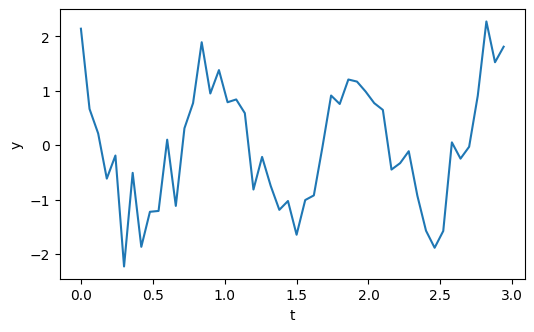

In [5]:
plt.plot(ts, ys)
plt.xlabel('t')
plt.ylabel('y');

Now let's see if we can use the signal to estimate the parameters.
The key idea is this trigonometric identity:

$$ \cos(\omega t + \phi) = \cos\phi \cos(\omega t) - \sin\phi \sin(\omega t) $$

In words, a cosine with a phase shift can be expressed as the weighted sum of a sine and cosine with no phase shift.
So you can estimate the amplitude and phase of a periodic signal by running a regression with a sine and cosine as predictors -- provided that you know the frequency of the periodic component.

To demonstrate, I'll put the data in a `DataFrame` along with these Fourier components.

In [6]:
data = pd.DataFrame(dict(ys=ys, ts=ts))
data['cos'] = np.cos(2 * np.pi * f * ts)
data['sin'] = np.sin(2 * np.pi * f * ts)

Now we can run the regression model (excluding the intercept, since we didn't include one in the synthesized signal).

In [7]:
import statsmodels.formula.api as smf

res = smf.ols('ys ~ 0 + cos + sin', data=data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     ys   R-squared (uncentered):                   0.815
Model:                            OLS   Adj. R-squared (uncentered):              0.808
Method:                 Least Squares   F-statistic:                              106.0
Date:                Sat, 18 Oct 2025   Prob (F-statistic):                    2.46e-18
Time:                        11:46:12   Log-Likelihood:                         -34.513
No. Observations:                  50   AIC:                                      73.03
Df Residuals:                      48   BIC:                                      76.85
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cos            1.2602      0.098     12.794      0.000       1.062       1.458
sin           -0.6846      0.098     -6.950      0.000      -0.883      -0.487
==============================================================================
Omnibus:                        0.306   Durbin-Watson:                   2.389
Prob(Omnibus):                  0.858   Jarque-Bera (JB):                0.244
Skew:                           0.160   Prob(JB):                        0.885
Kurtosis:                       2.877   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here's what the fitted model looks like compared to the data.

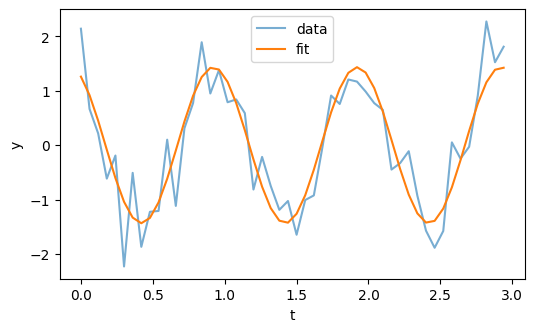

In [8]:
data['yhat'] = res.fittedvalues

plt.plot(data['ts'], data['ys'], label='data', alpha=0.6)
plt.plot(data['ts'], data['yhat'], label='fit')
plt.xlabel('t')
plt.ylabel('y')
plt.legend();

It looks like the fitted curve has recovered the phase of the periodic component.
The estimated amplitude and phase are not represented explicitly in the parameters of the model, but we can compute them -- basically by converting them from Cartesian to polar coordinates.

In [9]:
a = res.params['cos']
b = res.params['sin']

A_hat = np.hypot(a, b)     
phi_hat = np.arctan2(-b, a)

A_hat, phi_hat

(np.float64(1.4341371792799407), np.float64(0.49760870975866633))

It looks like we recovered the parameters, at least approximately.

Fourier analysis works on pretty much the same principle.
Instead of using sine and cosine, it uses a complex exponential.

In [10]:
ws = np.exp(2 * np.pi * 1j * f * ts)

We can estimate the parameters by computing the dot product of the complex exponential with the signal (which is basically correlation).

In [11]:
c = 2 / len(ts) * np.vdot(ws, ys)
c

np.complex128(1.2602143401738164+0.68455041144776j)

The result is a complex number that represents the estimated amplitude and phase of the signal.

In [12]:
A_hat = np.abs(c)
phi_hat = np.angle(c)

A_hat, phi_hat

(np.float64(1.4341371792799409), np.float64(0.49760870975866645))

And the estimated values are the same as what we got from linear regression.

This works because $ e^{i\theta} = \cos\theta + i\sin\theta $, so when we project the signal on a complex exponential basis, we're effectively computing the sine and cosine components in a compact form.
